# Introduction
We will use a Kalman filter to estimate the state mean $\mu_{t-1}$ and state variance $\sigma_{t-1}^2$ of industry returns at time $t - 1$. This estimate will be based on observations from $t - 24$ to $t - 1$. Using this information, we will construct a signal for investment at time $t$ of the form
$$
\mu_{t-1} - \frac{\gamma}{2}\sigma_{t-1}^2.
$$
We will suppose $\gamma = 1$ in our calculations. The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. The date range is from July 1927 to December 2020.

# Packages and Setup

In [76]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')

In [77]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

# Define window for Kalman filter
kal_win = 24

# Create training set
train = industry.loc[industry['Date'].dt.year <= 2005, :].reset_index(drop = True)

# Create testing set; make sure to add enough months to have a signal for January 2006
test = industry.loc[industry['Date'] >= train['Date'].max() - MonthEnd(kal_win - 1), :].reset_index(drop = True)

del industry

train.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,1926-07-31,0.0116,0.0403,0.0230,-0.0219,0.0221,0.0131,0.0069,0.0245,0.0485,0.0021
1,1926-08-31,0.0500,0.0028,0.0211,0.0441,0.0261,0.0108,-0.0003,0.0611,-0.0200,0.0453
2,1926-09-30,0.0003,-0.0334,0.0053,-0.0351,0.0086,0.0022,-0.0071,0.0080,0.0206,-0.0053
3,1926-10-31,-0.0255,-0.0946,-0.0511,0.0267,-0.0572,-0.0099,-0.0328,0.0013,-0.0298,-0.0251
4,1926-11-30,0.0600,-0.0038,0.0169,0.0159,0.0132,0.0148,0.0135,0.0720,0.0571,0.0085


# Training Set Results
We will use the EM method of the Kalman filter instance to estimate the the parameters of the Kalman filter.

In [78]:
# Create function to calculate Kalman momentum
def calc_kal_mom(data, window):

    # Record the number of variables; one fewer than the number of columns in data
    n = len(data.columns) - 1

    # Save identity matrix
    I = np.eye(n)

    # Create data frame to record signal values
    kal_mom = pd.DataFrame(index = data.index[window:], columns = data.columns)

    # Create filter
    kf = KalmanFilter(initial_state_mean = np.zeros(n),
                initial_state_covariance =  0.10**2 * I,
                transition_matrices = I,
                transition_covariance = I,
                observation_matrices = I,
                observation_covariance = 0.10**2 * I)

    # We will loop over the date
    dates = np.unique(data['Date'])[window:]

    for date in dates:
    
        # Obtain the end of the signal formation, exclusive
        stop = np.sum(data['Date'] < date)
    
        # Record the beginning of signal, inclusive
        start = stop - kal_win
    
        # Get 'measurement' values for Kalman filter
        X = np.array(data.iloc[start:stop, 1:])
    
        try:
        
            kf = kf.em(X, n_iter = 5)
            mu, sigma = kf.smooth(X)
    
        except:
        
            # If det(X'X) is too small for Kalman filter, use 0 as state estimates
            mu, sigma = [np.zeros(n)], [np.zeros((n, n))]
    
        # Record date for later merger
        kal_mom.loc[stop, 'Date'] = date    
    
        # Record signal
        kal_mom.loc[stop, data.columns[1:]] = mu[-1] - 0.5 * np.diag(sigma[-1])
        
    # Convert data column to data-time object
    kal_mom['Date'] = pd.to_datetime(kal_mom['Date'])
    
    # Change structure of data frame so industries are observations
    kal_mom = pd.melt(kal_mom, id_vars = ['Date'], value_vars = kal_mom.columns[1:])

    # Change column names
    kal_mom.columns = ['Date', 'Industry', 'Kal_mom']
        
    return kal_mom

# Create the data frame for signal
kal_mom_train = calc_kal_mom(data = train, window = kal_win)
    
kal_mom_train.head()

,Date,Industry,Kal_mom
0,1928-07-31,NoDur,-0.0421504
1,1928-08-31,NoDur,-0.0103538
2,1928-09-30,NoDur,0.0115828
3,1928-10-31,NoDur,0.0280554
4,1928-11-30,NoDur,0.0207193


In [79]:
# Create function that combines returns with signal and then implements strategy
def calc_strg_rtn(returns, signal, quants):

    # Change structure of data frame so industries are observations
    returns = pd.melt(returns, id_vars = ['Date'], value_vars = returns.columns[1:])

    # Change column names
    returns.columns = ['Date', 'Industry', 'Ret']
    
    # Perform merge
    df = returns.merge(signal, on = ['Date', 'Industry'])

    # Calculate quintiles
    df['Quintile'] = df[['Date', 'Kal_mom']].groupby('Date')['Kal_mom'].transform(lambda x: 
                                                                                  pd.qcut(x, quants, labels = False))

    # Add 1 to quintile to avoid confusion
    df['Quintile'] = 1 + df['Quintile']

    # Drop columns that have done their jobs
    df.drop(['Kal_mom', 'Industry'], axis = 1, inplace = True)
    
    # Calculate equally weighted returns for each quintile
    result = df.groupby(['Date', 'Quintile'])['Ret'].mean().reset_index()

    # Make each quintile its own column
    result = result.pivot(index = 'Date', columns = 'Quintile', values = 'Ret').reset_index()

    # Calculate winners minus losers
    result['WML'] = result[quants] - result[1]
    
    return result

# Create data frame for returns
result_train = calc_strg_rtn(returns = train, signal = kal_mom_train, quants = 5)

result_train.head()

Quintile,Date,1,2,3,4,5,WML
0,1928-07-31,0.00175,0.00970,-0.00550,0.01075,-0.00320,-0.00495
1,1928-08-31,0.07455,0.06175,0.01655,0.07550,0.06585,-0.00870
2,1928-09-30,0.04025,0.02910,0.04085,0.07620,0.01610,-0.02415
3,1928-10-31,0.03770,0.01685,0.01115,0.02060,0.00895,-0.02875
4,1928-11-30,0.12655,0.16225,0.06200,0.10175,0.11665,-0.00990


In [80]:
# Create function which gives return statistics
def get_rtn_stats(result):
    
    # Create data frame for return statistics
    stats = pd.DataFrame(index = result.columns[1:])

    # Take a look at the mean
    stats['mean'] = 12 * result.mean()

    # Take a look at the sd
    stats['sd'] = 12**(1/2) * result.std()

    # Take a look at the skew
    stats['skew'] = 12**(3/2) * result.skew()

    return stats

# Obtain return statistics for training set
get_rtn_stats(result_train)

,mean,sd,skew
Quintile,,,
1,0.080884,0.271956,51.743079
2,0.136150,0.261661,60.019764
3,0.149611,0.249754,44.178467
4,0.180588,0.255342,59.584387
5,0.235189,0.257467,43.402377
WML,0.154305,0.184818,-42.051276


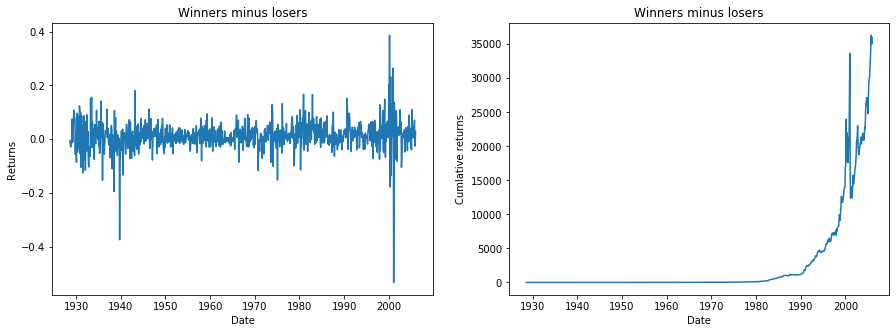

In [81]:
# Create function to plot results
def plot_result(result):

    # Plot returns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

    ax1.plot(result['Date'], result['WML'])
    ax1.set_xlabel('Date') 
    ax1.set_ylabel('Returns') 
    ax1.set_title('Winners minus losers') 

    ax2.plot(result['Date'], (1 + result['WML']).cumprod() - 1) 
    ax2.set_xlabel('Date') 
    ax2.set_ylabel('Cumlative returns') 
    ax2.set_title('Winners minus losers') 

    plt.show()
    
plot_result(result_train)

# Testing Set Results

In [82]:
# Create the data frame for signal
kal_mom_test = calc_kal_mom(data = test, window = kal_win)
    
kal_mom_test.head()

,Date,Industry,Kal_mom
0,2006-01-31,NoDur,-0.00517653
1,2006-02-28,NoDur,0.0258946
2,2006-03-31,NoDur,0.03089
3,2006-04-30,NoDur,0.0392716
4,2006-05-31,NoDur,0.0136676


In [83]:
# Create data frame for returns
result_test = calc_strg_rtn(returns = test, signal = kal_mom_test, quants = 5)

result_test.head()

Quintile,Date,1,2,3,4,5,WML
0,2006-01-31,0.04455,0.04465,0.08065,0.0840,0.14690,0.10235
1,2006-02-28,0.00830,0.00905,0.00880,0.0155,-0.05650,-0.06480
2,2006-03-31,0.02535,0.04670,0.03890,0.0484,0.04385,0.01850
3,2006-04-30,0.03410,0.00905,-0.00805,0.0057,0.02100,-0.01310
4,2006-05-31,-0.05610,-0.04300,-0.03460,-0.0249,-0.05825,-0.00215


In [84]:
get_rtn_stats(result_test)

,mean,sd,skew
Quintile,,,
1,0.026800,0.293955,13.268291
2,0.100080,0.229428,-2.036945
3,0.096600,0.231890,-15.057574
4,0.150200,0.200897,-2.841784
5,0.154183,0.222915,13.443581
WML,0.127383,0.201377,-30.799669


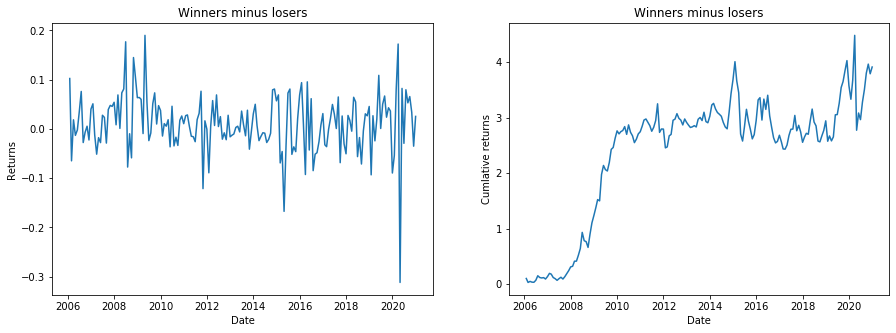

In [85]:
plot_result(result_test)